# パーティクルフィルタによる自己位置推定

In [1]:
import sys
sys.path.append('../src')
import importlib

import drawables
import particles
import numpy as np

def reload():
    importlib.reload(drawables)
    importlib.reload(particles)

reload()

<IPython.core.display.Javascript object>


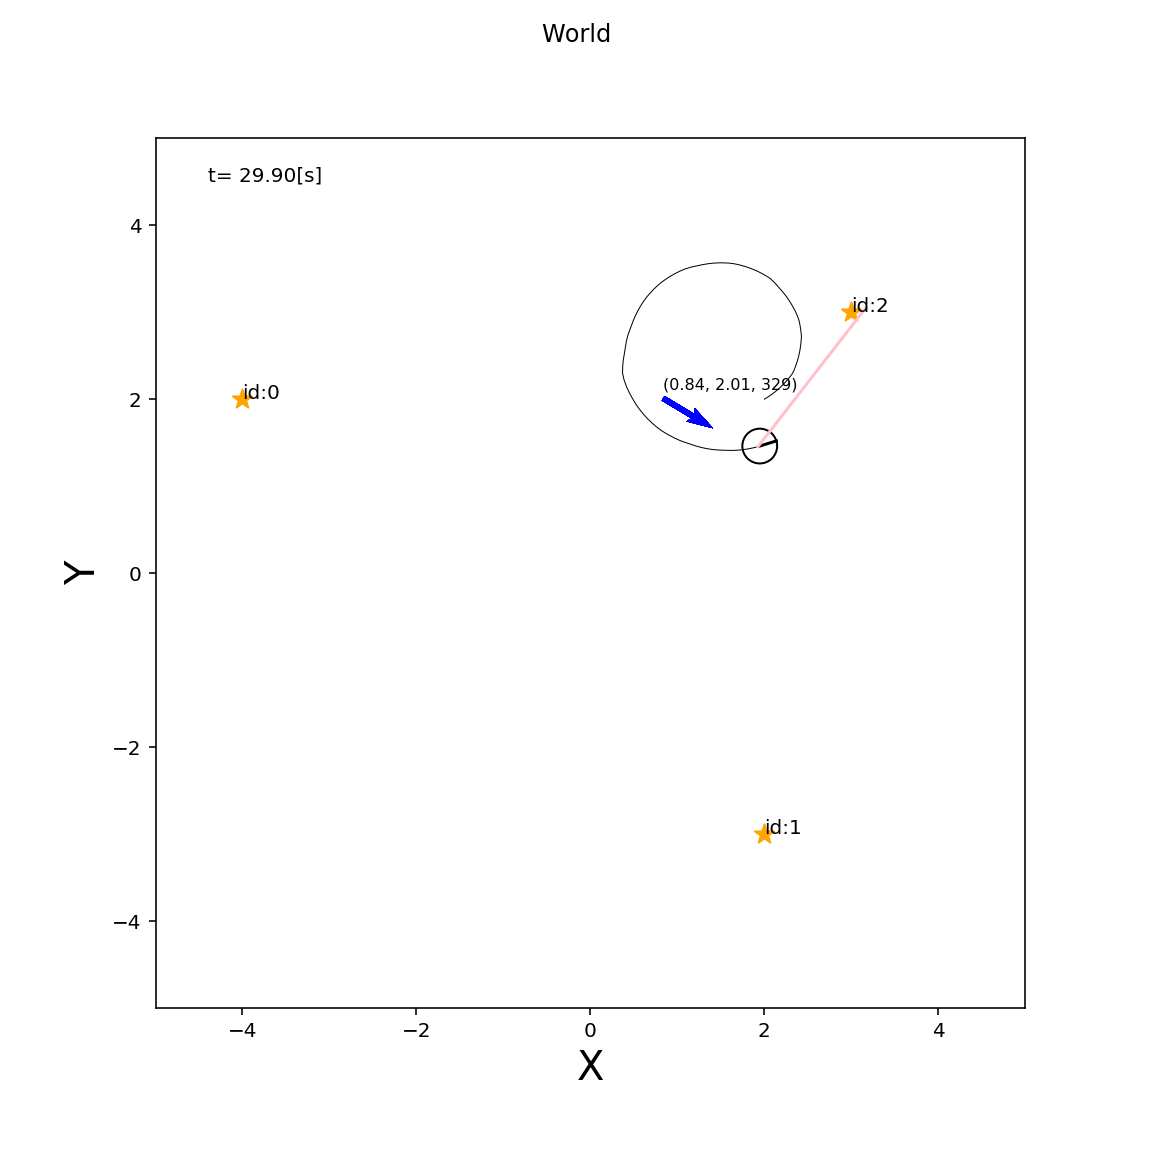

In [4]:
# 手始めにパーティクルを表示
reload()
sim = drawables.Simulator(30., 0.1, debuggable=False)
m = drawables.DrawableMap()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(drawables.DrawablePoint2DLandmark(*ln))
sim.append(m)
    
init_pose = np.array([2., 2., np.pi / 6.]).T
estimator = drawables.DrawableMcl(
    m, init_pose,
    [particles.SimpleParticle(init_pose, 0.01) for i in range(100)],
    motion_noise_stds={'nn':0.00001, 'no': 0.00001, 'on': 0.00001, 'oo': 0.00001})
circling = drawables.DrawableEstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)
r = drawables.DrawableRealRobot(init_pose, sensor=drawables.DrawableCamera(m), agent=circling)
sim.append(r)
sim.draw()

パーティクルの更新

状態遷移モデルを作ろう

シミュレータでロボットの挙動の統計をとって，作っていく

ノイズが正規分布に従うと仮定してみる

指数分布に従うノイズを入れたりしているが，まずはこれで

このときの雑音パラメータを

- $\sigma_{\nu \nu}$ : 直進1mで生じる道のりのばらつきのstddev
- $\sigma_{\nu \omega}$ : 回転1radで生じる道のりのばらつきのstddev
- $\sigma_{\omega \nu}$ : 直進1mで生じる回転のばらつきのstddev
- $\sigma_{\omega \omega}$ : 回転1radで生じる回転のばらつきのstddev

$\sigma_{a b}$は，$b$が$a$にあたえるばらつきのstddevを表す

$b$があたえる雑音$\delta_{ab}$は移動量・回転量に比例するので

$$
\delta^{2}_{ab} : \left(\delta^{\prime}_{ab} \Delta t \right)^{2} = 1 : |b| \Delta t \\
\\
\delta^{\prime}_{ab} = \delta_{ab} \sqrt{|b| / \Delta t}
$$

$a$, $b$に$\nu$, $\omega$を代入すると制御指令に加えるべき雑音がわかる

これを${\bf \it u}^{\prime}$とすると

$$
\left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) = \left(
    \begin{array}{c}
        \nu^{\prime} \\
        \omega^{\prime}
    \end{array}
\right) + \left(
    \begin{array}{c}
        \delta_{\nu \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \nu} \sqrt{|\omega|  / \Delta t} \\
        \delta_{\omega \nu} \sqrt{|\nu| / \Delta t} + \delta_{\omega \omega} \sqrt{|\omega|  / \Delta t}
\end{array}
\right)
$$

シミュレータでロボットを走らせて，これらの値を計測する

In [6]:
# 実装確認コード
reload()

init_pose = np.array([0., 0., 0.]).T
estimator = drawables.DrawableMcl(
    m, init_pose, [particles.SimpleParticle(init_pose, 0.01) for i in range(100)], 
    motion_noise_stds={'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})
a = drawables.DrawableEstimationAgent(0.1, 0.2, 10./180.*np.pi, estimator)
estimator.motion_update(0.2, 10./180.*np.pi, 0.1)
for p in estimator._particles:
    print(p.pose)

[0.02107497 0.00015455 0.01466631]
[0.02347072 0.00025191 0.02146492]
[0.01523325 0.00020462 0.02686395]
[0.01775822 0.00022298 0.02511154]
[0.01915464 0.000185   0.01931577]
[0.01548973 0.00023872 0.03082115]
[0.01952744 0.0001935  0.01981782]
[0.01876715 0.00015856 0.01689736]
[0.01417488 0.00014917 0.02104614]
[0.01913584 0.0001247  0.01303248]
[0.01532729 0.0001543  0.0201335 ]
[1.84050861e-02 9.04936484e-05 9.83346871e-03]
[0.01597984 0.00018433 0.02306922]
[0.01880061 0.0001165  0.01239289]
[0.02556959 0.00026014 0.02034689]
[0.01734916 0.00022003 0.02536406]
[0.01742526 0.0001389  0.01594202]
[0.02713395 0.00025242 0.01860511]
[0.0195418  0.00028996 0.02967405]
[0.01773079 0.0001669  0.01882598]
[0.01919959 0.00013935 0.01451588]
[0.01980906 0.00020944 0.02114492]
[2.14080365e-02 8.82995466e-05 8.24914940e-03]
[0.02165443 0.00018868 0.0174264 ]
[0.01526044 0.00014038 0.01839767]
[1.91170582e-02 7.49827176e-05 7.84454724e-03]
[2.23227994e-02 6.33593873e-05 5.67663722e-03]
[0.0218

<IPython.core.display.Javascript object>


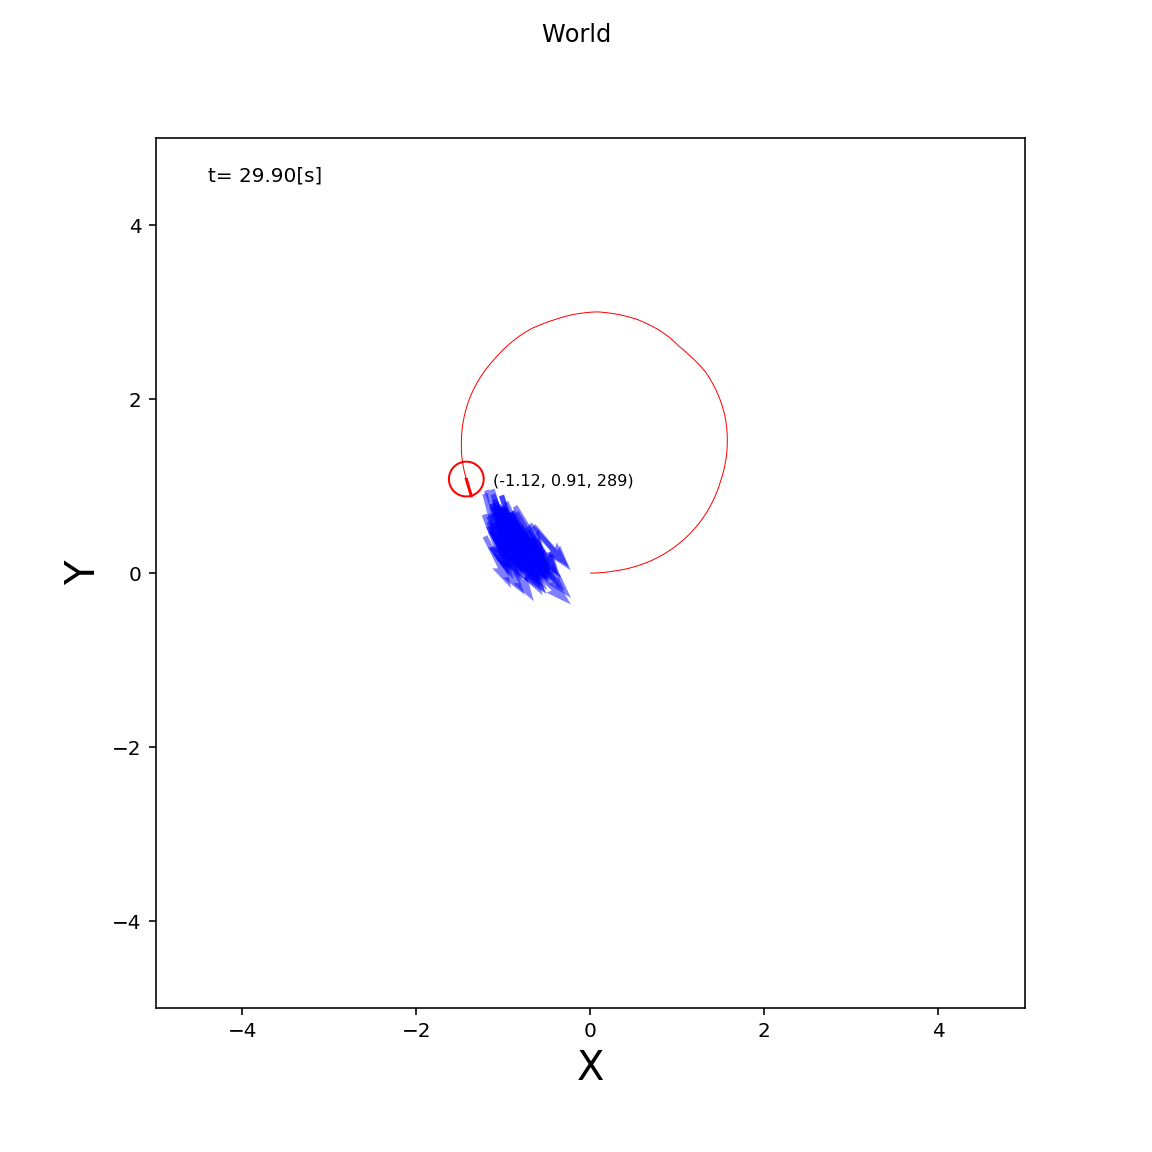

In [8]:
# パーティクルのノイズパラメータを適当に与えてばらつかせてみる
reload()
def trial(motion_noise_stds):
    time_interval = 0.1
    sim = drawables.Simulator(30., time_interval)
    map_ = drawables.DrawableMap()
    
    initial_pose = np.array([0., 0., 0.]).T
    estimator = drawables.DrawableMcl(
        map_, initial_pose,
        [particles.SimpleParticle(initial_pose, 0.01) for i in range(100)],
        motion_noise_stds=motion_noise_stds)
    circling = drawables.DrawableEstimationAgent(
        0.1, 0.2, 10./180.*np.pi, estimator=estimator)
    r = drawables.DrawableRealRobot(initial_pose, sensor=None, agent=circling, color='red')
    sim.append(r)
    
    sim.draw()
    
trial({'nn':0.01, 'no': 0.02, 'on': 0.03, 'oo': 0.04})

<IPython.core.display.Javascript object>


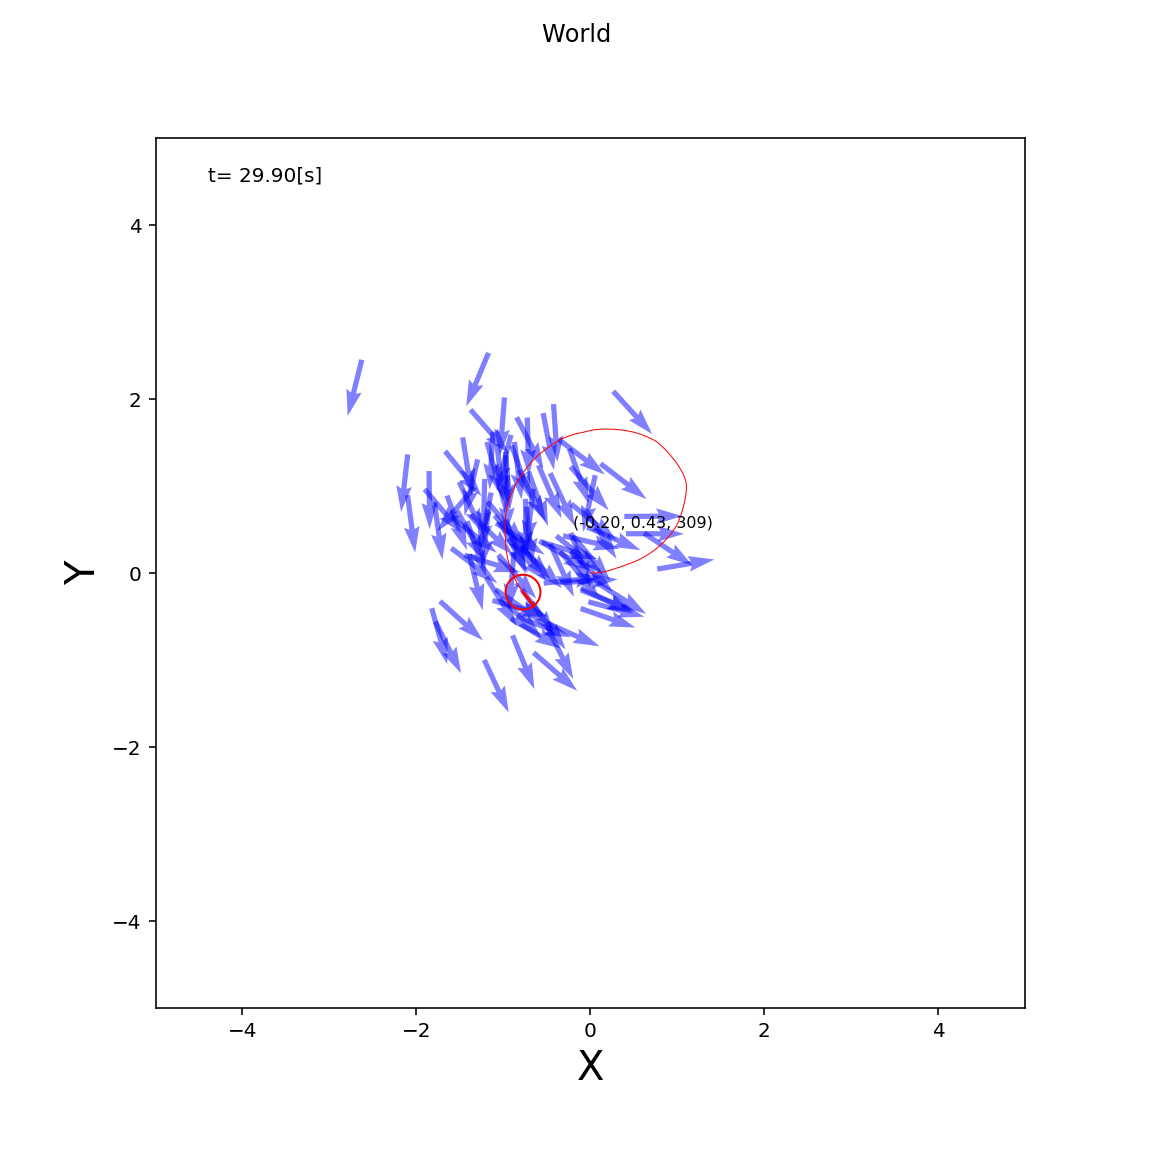

In [9]:
# motion_model_parameterノートブックで求めたパラメータを与えたときのパーティクルの分布
reload()
trial({'nn':0.19, 'no': 0.0001, 'on': 0.13, 'oo': 0.2})

このときのパーティクルフィルタの分布

$$
P({\bf \it x}^{*} \in \it X) = \int_{x \in X} b_{t}(\bf \it x) d {\bf \it x} \approx \frac{1}{N} \sum_{i=0}^{N-1}\delta({\bf \it x}_{i}^{(i)} \in X)
$$

$\delta (\cdot)$は中身がTrueなら1, Falseなら0を返す関数

X内にあるパーティクルの割合を計算し，

その値を

ロボットの姿勢が$X$ないにある確率とする

In [4]:
# パーティクルに観測後の結果を反映させていく
reload()

# 検証用の関数
def trial():
    time_interval = 0.1
    sim = drawables.Simulator(30., time_interval, debuggable=False)
    
    m = drawables.DrawableMap()
    for ln in [(-4., 2.), (2., -3.), (3., 3.)]:
        m.append_landmark(drawables.DrawablePoint2DLandmark(*ln))
    m.append(m)
    initial_pose = np.array([0., 0., 0.]).T
    estimator = drawables.DrawableMcl(m, initial_pose, 100)
    a = drawables.DrawableEstimationAgent(
        time_interval, 0.2, 10./180.*np.pi, estimator=estimator)
    r = drawables.DrawableRealRobot(initial_pose, sensor=sensors.Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()

## パーティクルの自己位置をセンサ値から

数式はむずいので，

- 実装
- 本読む
- コメントとlatexで補強

という形で進める

尤度関数のための観測ばらつきの計測はは別notebook sensor_experiment.ipynbで

コミットID f4cf4f74f08378d91bb4e のline 61 でweightに掛け合わせている値は

$$
\it L_{j} ({\bf \mathit x } \mid {\bf \it z}_{j}) = {\mathit N} ( {\bf \mathit z} = {\bf \mathit z}_{j} \mid {\bf \mathit h}_{j} ({\bf \mathit x} ), {\mathit Q}_{j} ({\bf \mathit x}) )
$$

センサ値を固定して，条件付き独立で正規分布であることを期待する

<IPython.core.display.Javascript object>


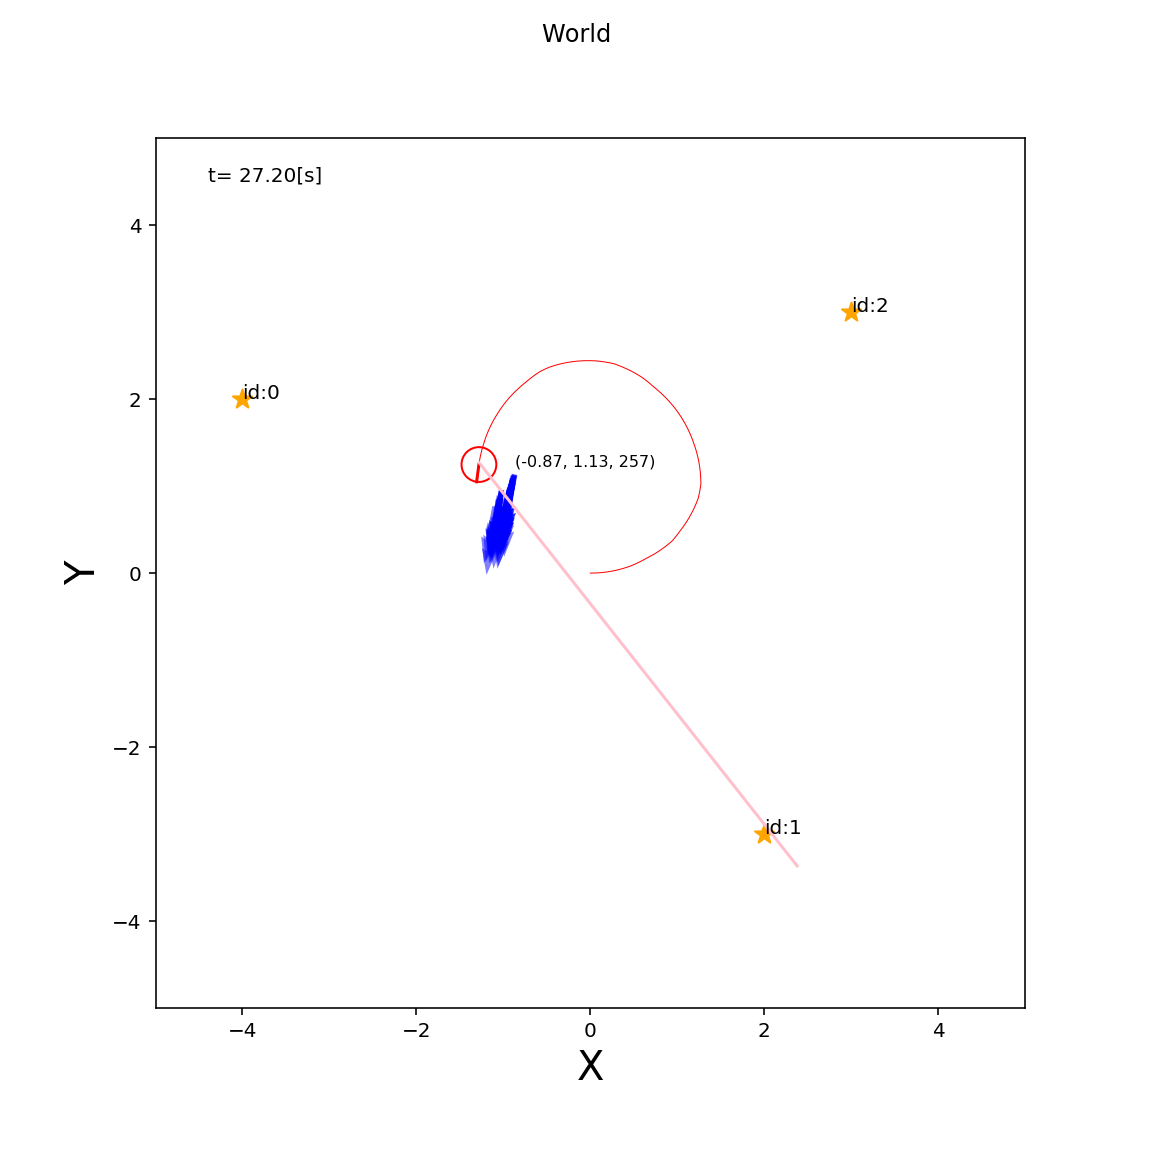

In [5]:
trial()